## Семинар 7: "Методы оптимизации"

ФИО: Мещанинов Вячеслав

In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata

import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable
from train_utils import train
%matplotlib notebook
import copy
import random
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import seaborn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [130]:
class My_Optimizer():
    def __init__(self, f, df, init=(1,1), lr=0.1):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32') ## weigths        
        self.lr = lr
        
    def step(self, loss):
        raise RuntimeError('Not implemented!!!')
            
class GD(Optimizer):
    def __init__(self, f, df, init, lr):
        super().__init__(f, df, init, lr)
        
    def step(self):
        self.theta -= self.lr * self.df(self.theta)
                
class Momentum(Optimizer):
    ## v_t = g*v_t-1 + l*grad 
    ## g - gamma, l - learning_rate
    ## w_t = w_t-1 - v_t
    def __init__(self, f, df, init, lr, gamma=0.9):
        super().__init__(f, df, init, lr)
        self.gamma = gamma
        self.v = 0
        
    def step(self):
        self.v = self.v * self.gamma + self.lr * self.df(self.theta)
        self.theta -= self.v
                
class NAG(Optimizer):
    ## v_t = g * v_t-1 + l * grad(w_t-1 - g * v_t-1)
    ## w_t = w_t-1 - v_t
    def __init__(self, f, df, init, lr, gamma=0.9):
        super().__init__(f, df, init, lr)
        self.gamma = gamma
        self.v = 0
        
    def step(self):
        self.v = self.v * self.gamma + self.lr * self.df(self.theta - self.v * self.gamma)
        self.theta -= self.v
                
class Adagrad(Optimizer):
    ## G_t = G_t-1 + grad(w) ** 2
    ## w_t+1 = w_t - l * h_t / sqrt(G_t + e)
    def __init__(self, f, df, init, eps=1e-8):
        super().__init__(f, df, init, lr)
        self.eps = eps
        self.G = np.zeros_like(self.theta)
        
    def step(self):
        g = self.df(self.theta)
        self.G += g ** 2
        self.theta -= self.lr / np.sqrt(self.G + self.eps) * g
                
class Adadelta(GD):
    ## G_t = g * G_t-1 + (1 - g) * grad(w)**2 
    ## dw = l * sqrt(( G_dw_t-1 + e) / (G_t + e)) * grad(w)
    ## G_dw = g * G_dw_t-1 + (1 - g) * dw**2
    ## w -= dw
    def __init__(self, f, df, init, lr, gamma=0.01, eps=1e-8):
        super().__init__(f, df, init, lr)
        self.gamma = gamma
        self.eps = eps
        self.EG = np.zeros_like(self.theta)
        self.EDelta = np.zeros_like(self.theta)
        
    def _update(self, lr):
        g = self.df(self.theta)
        self.EG = self.gamma * self.EG + (1 - self.gamma) * g ** 2
        dtheta = lr * np.sqrt((self.EDelta + self.eps) / (self.EG + self.eps)) * g
        self.EDelta = self.gamma * self.EDelta + (1 - self.gamma) * dtheta ** 2
        self.theta -= dtheta
            
class Adam(GD):
    ## m_t = b1*m_t-1 + (1 - b1) * g_t
    ## v_t = b2*v_t-1 + (1 - b2) * g_t^2
    ## w_t+1 = w_t - l * m_t / (sqrt(v_t) + e)
    def __init__(self, func, lr=0.1, init=(1,1), b1=0.9, b2=0.999, eps=1e-8):
        GD.__init__(self, func, lr)
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.m_ = []
        slef.v_ = []
            
    def step(self):
        df = self.func.derivative()

In [3]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
    
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate=0.1):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J
        loss.backward()
        
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                v.grad.data.zero_()
                
                
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate=0.1, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                v -= moment
                v.grad.data.zero_()
                
                
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate=0.1, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                v += moment
                moment += self.lr * v.grad
                v -= moment
                v.grad.data.zero_()
              
            
            
class Adagrad(Optimizer):
    ## G_t = G_t-1 + grad(w) ** 2
    ## w_t+1 = w_t - l * h_t / sqrt(G_t + e)
    def __init__(self, variables, learning_rate=0.1, eps=10**-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J
        loss.backward()
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                v.grad.data.zero_()
             
            

class Adadelta(Optimizer):
    ## G_gr_t = g * G_gr_t-1 + (1 - g) * grad(w)**2 
    ## dw = l / sqrt(G_gr_t + e) * grad(w)
    ## G_dw = g * G_dw_t-1 + (1 - g) * dw**2
    ## w -= dw
    def __init__(self, variables, learning_rate=0.01, eps=10**-8, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        self.gamma = gamma
        self.G_gr = []
        self.G_dw = []
        for v in self.variables:
            self.G_gr.append(torch.zeros_like(v.data))
            self.G_dw.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J
        loss.backward()
        with torch.no_grad():
            for v, G_gr, G_dw in zip(self.variables, self.G_gr, self.G_dw): 
                G_gr = self.gamma * G_gr + (1 - self.gamma) * (v.grad ** 2)
                dw = self.lr / np.sqrt(G_gr + self.eps) ** (1 / 2) * v.grad
                G_dw = self.gamma * G_dw + (1 - self.gamma) * (dw ** 2)
                v -= dw
                v.grad.data.zero_()
                
                
class Adam(Optimizer):
    ## m_t = b1*m_t-1 + (1 - b1) * g_t
    ## v_t = b2*v_t-1 + (1 - b2) * g_t^2
    ## w_t+1 = w_t - l * m_t / (sqrt(v_t) + e)
    def __init__(self, variables, learning_rate=0.1, eps=10**-8, b1=0.9, b2=0.999):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        self.b1 = b1
        self.b2 = b2
        self.m = []
        self.v = []
        for w in self.variables:
            self.m.append(torch.zeros_like(w.data))
            self.v.append(torch.zeros_like(w.data))
            
    def step(self, J):
        loss = J
        loss.backward()
        with torch.no_grad():
            for w, m, v in zip(self.variables, self.m, self.v): 
                m = self.b1 * m + (1 - self.b1) * w.grad
                v = self.b2 * v + (1 - self.b2) * w.grad ** 2
                m = m / (1 - self.b1)
                s = v / (1 - self.b2)
                w -= self.lr * m / (s + self.eps).sqrt()
                w.grad.data.zero_()      

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [160]:
def J1(X, Y):
    return X**2 / 10 + Y**2 / 10

In [161]:
def apply_opt(x, y, optimizer, J, n_iters=1000):    
    points = []
    X = Variable(torch.tensor(float(x)), requires_grad=True)
    Y = Variable(torch.tensor(float(y)), requires_grad=True) 
    print(X, Y)
    opt = optimizer([X, Y])
    
    for i in range(n_iters):
        points.append((X.item(), Y.item(), J(X, Y).item()))
        opt.step(J(X, Y))

    points = np.array(points)
    return points

In [179]:
def paint(J, optimizers):
    fig = plt.figure(figsize=(10, 10))
    R = 10
    X = np.linspace(-R, R, 100)
    Y = np.linspace(-R, R, 100)
    xx, yy = np.meshgrid(X, Y)
    xx = torch.from_numpy(xx)
    yy = torch.from_numpy(yy)
    Z = J(xx, yy)
    
    #set axes
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(-R, +R)
    ax.set_ylim3d(-R, +R)
    ax.set_zlim3d(-R, +R)
    ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy(), color='black')
    #paint optimizers
    for opt in optimizers:
        x = np.random.randint(6, 10, 1) * (-1) ** (np.random.randint(6, 12, 1))
        y = np.random.randint(6, 10, 1) * (-1) ** (np.random.randint(6, 12, 1))
        points = apply_opt(x, y, lambda x: opt(x), J, 500)
        ax.plot(points[:, 0], points[:, 1], points[:, 2], label=opt, linewidth=3)
    plt.legend(fontsize=14)
    plt.show()

<IPython.core.display.Javascript object>


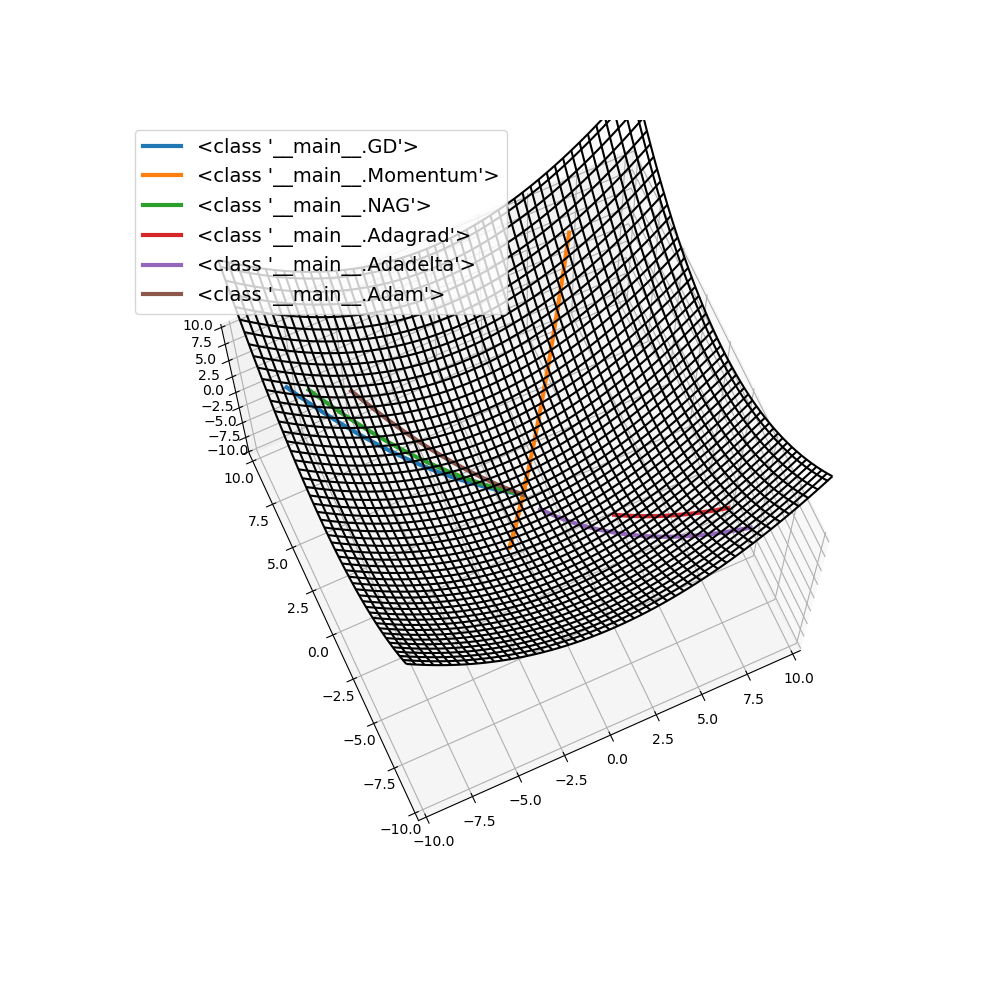

tensor(-9., requires_grad=True) tensor(6., requires_grad=True)
tensor(6., requires_grad=True) tensor(8., requires_grad=True)
tensor(-8., requires_grad=True) tensor(6., requires_grad=True)
tensor(7., requires_grad=True) tensor(-7., requires_grad=True)
tensor(7., requires_grad=True) tensor(-9., requires_grad=True)
tensor(-6., requires_grad=True) tensor(6., requires_grad=True)


In [180]:
optimizers = [GD, 
              Momentum,
              NAG, 
              Adagrad, 
              Adadelta,
              Adam]
paint(J1, optimizers)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [181]:
def J2(X, Y):
    return X**2 * X.sin() / 10 + Y**2 * Y.sin() / 10

<IPython.core.display.Javascript object>


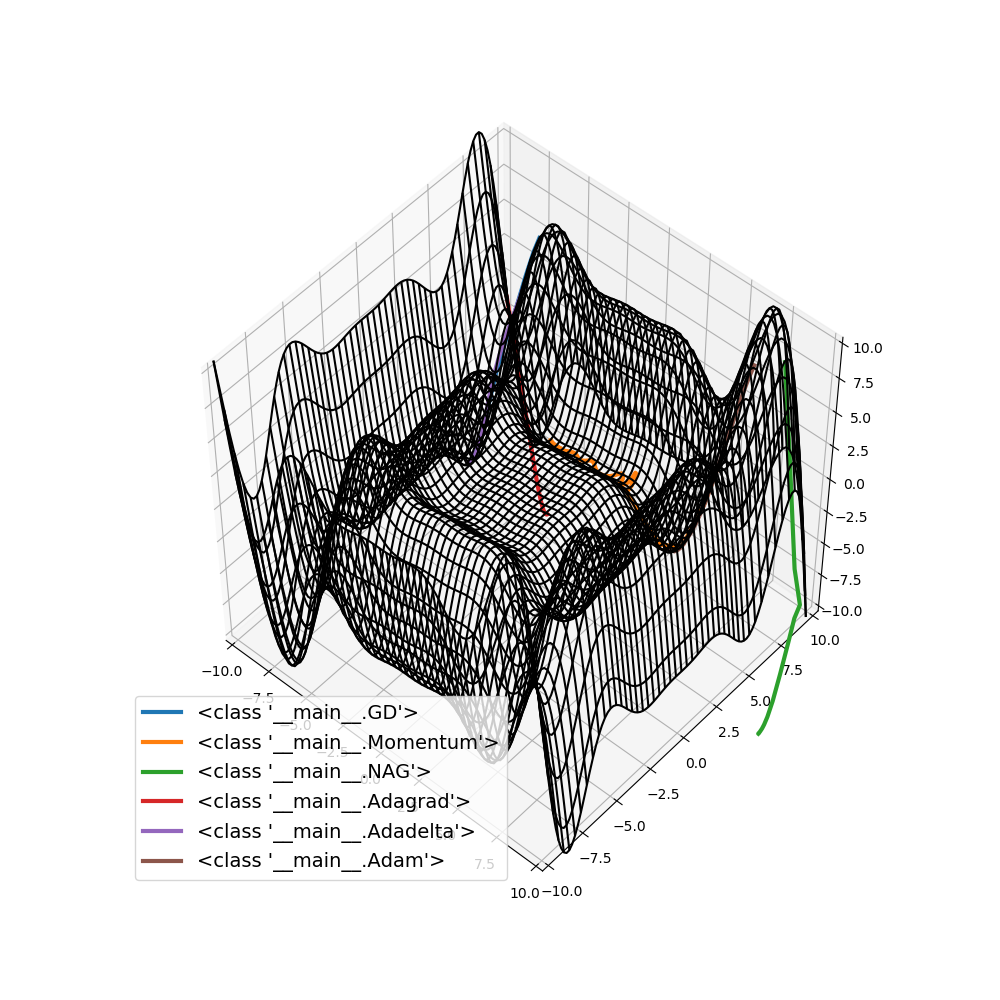

tensor(-6., requires_grad=True) tensor(8., requires_grad=True)
tensor(7., requires_grad=True) tensor(6., requires_grad=True)
tensor(9., requires_grad=True) tensor(8., requires_grad=True)
tensor(-9., requires_grad=True) tensor(9., requires_grad=True)
tensor(-7., requires_grad=True) tensor(8., requires_grad=True)
tensor(8., requires_grad=True) tensor(7., requires_grad=True)


In [187]:
paint(J2, optimizers)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

Я решил добавить чиселки для сглаживания, так как иначе невозможно анализировать график

In [219]:
def J3(X, Y):
    return ((X ** 2 / 50) * (X ** 2 / 50).sin()  + (Y ** 2 / 50) * (Y ** 2 / 50).sin()) 

<IPython.core.display.Javascript object>


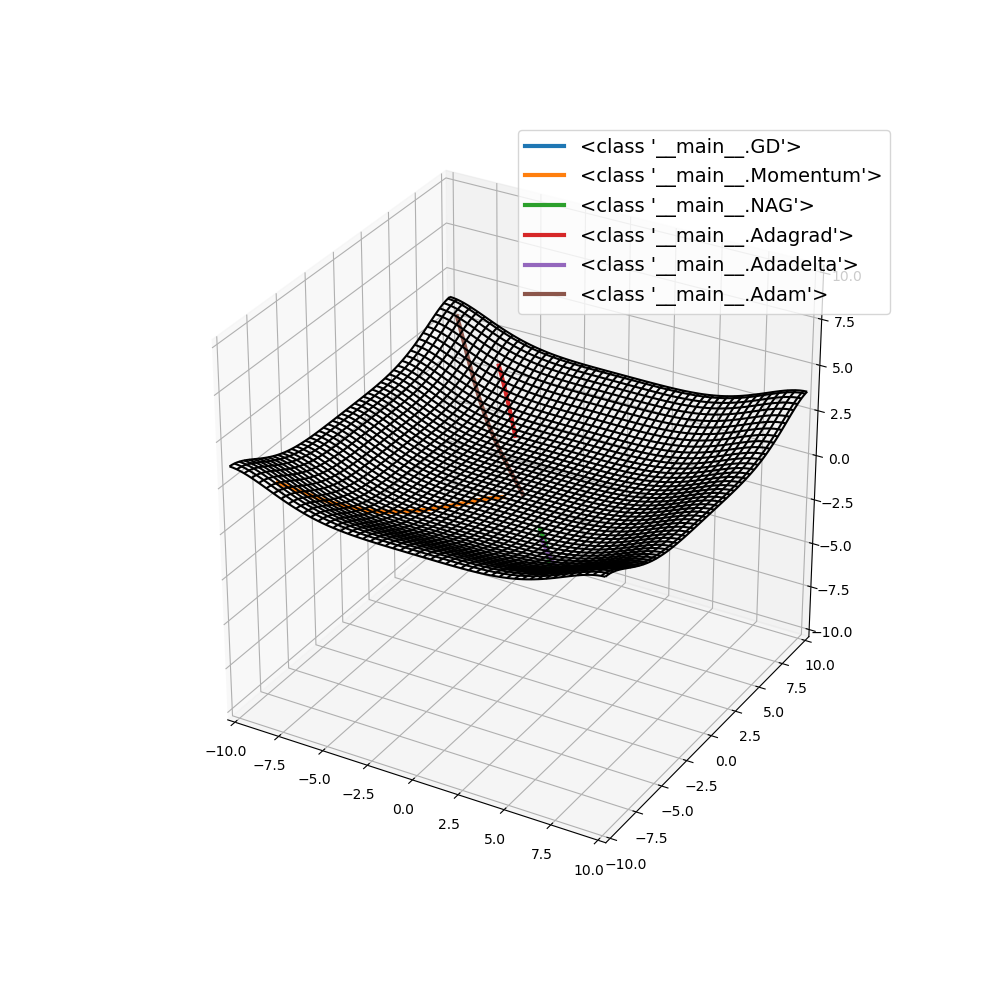

tensor(7., requires_grad=True) tensor(-9., requires_grad=True)
tensor(-8., requires_grad=True) tensor(-9., requires_grad=True)
tensor(7., requires_grad=True) tensor(-9., requires_grad=True)
tensor(-6., requires_grad=True) tensor(8., requires_grad=True)
tensor(6., requires_grad=True) tensor(-7., requires_grad=True)
tensor(-9., requires_grad=True) tensor(9., requires_grad=True)


In [220]:
paint(J3, optimizers)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [22]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [23]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

In [73]:
def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        X = X.view(X.size(0), -1)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, opt, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = opt(network.parameters(), lr=learning_rate)#torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs

In [74]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [75]:
loss = nn.NLLLoss()
optimizers = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.SGD]

Epoch 4... (Train/Test) NLL: 0.386/0.354	Accuracy: 0.896/0.901


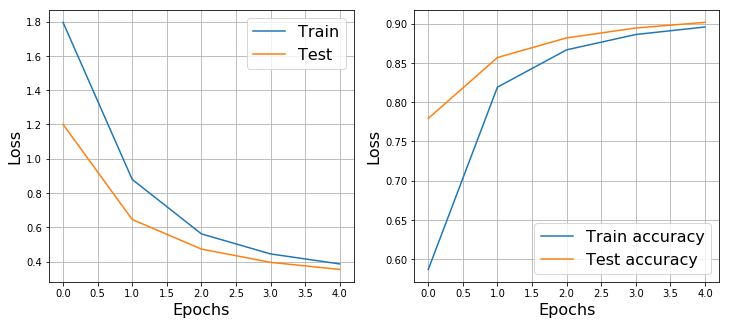

In [77]:
train_, test = [], []
for i, opt in enumerate(optimizers):
    net = nn.Sequential(nn.Linear(784, 200),
                        nn.Tanh(),
                        nn.Linear(200, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax(dim=1))
    train_loss_epochs, test_loss_epochs = train(net, train_loader, test_loader, 5, 0.001, opt)
    train_.append(train_loss_epochs)
    test.append(test_loss_epochs)

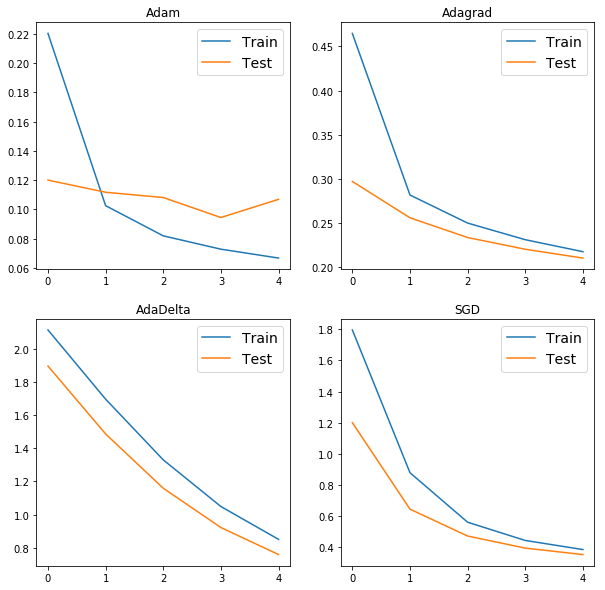

In [78]:
fig = plt.figure(figsize=(10, 10))
titles = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']
ax = []
for i, opt in enumerate(optimizers):
    ax.append(fig.add_subplot(221 + i))
    ax[i].plot(train_[i][:], label='Train')
    ax[i].plot(test[i][:], label='Test')
    ax[i].legend(fontsize=14)
    ax[i].set_title(titles[i])

plt.show()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [66]:
class Net_conv(nn.Module):
    def __init__(self):
        super(Net_conv, self).__init__()
        self.conv_layer = nn.Sequential(nn.Conv2d(1, 16, (3, 3), padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))      

        self.linear_layer = nn.Sequential(nn.Linear(196 * 16, 10), nn.LogSoftmax(dim = 1))
    
    def forward(self, x):
        x = self.conv_layer(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear_layer(x)
        return x

Epoch 4... (Train/Test) NLL: 0.259/0.241	Accuracy: 0.926/0.933


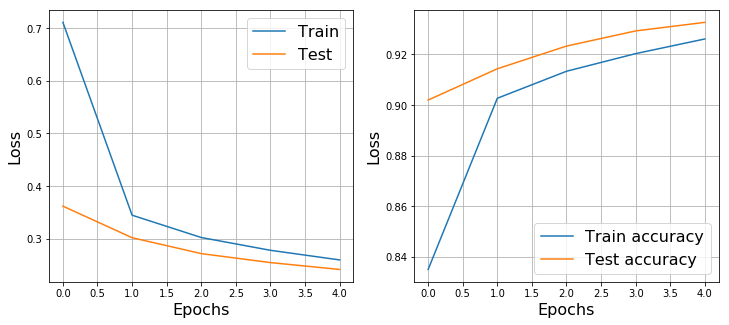

In [67]:
train_ = []
test = []
for i, opt in enumerate(optimizers):
    net = Net_conv()
    train_loss_epochs, test_loss_epochs = train(net, train_loader, test_loader, 5, 0.001, opt)
    train_.append(train_loss_epochs)
    test.append(test_loss_epochs)

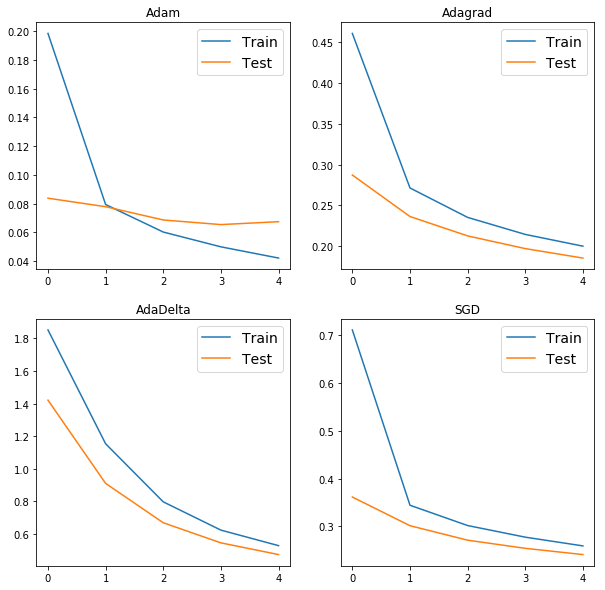

In [68]:
fig = plt.figure(figsize=(10, 10))
titles = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']
ax = []
for i, opt in enumerate(optimizers):
    ax.append(fig.add_subplot(221 + i))
    ax[i].plot(train_[i][:], label='Train')
    ax[i].plot(test[i][:], label='Test')
    ax[i].legend(fontsize=14)
    ax[i].set_title(titles[i])

plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: